# Clustering

With dimension reduction out of the way, we now look at another large part of unsupervised learning: clustering. Clustering seeks to find the "labels" in the dataset given that we have no idea what they should be (or how many there should be).

To begin we load some Python libraries we'll need. As always we need `numpy`, `matplotlib`, and various classes from `sklearn`. We also use the `pandas` library, a very useful library for data processing, to load in the data from an internet `csv` file. The `scipy` library is used to perform hierarchical clustering later on since it is able to show tree plots. As usual, we also set a random seed to allow for replication of our results.

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import fetch_mldata
np.random.seed(42)

Next, we define several support functions that will be used. The first function loads in our input data and returns it as the usual array. The rest generate various plots that we'll talk about in more detail below.

In [12]:
def get_data(size=5000):
    mnist = fetch_mldata('MNIST original')
    down_sample = np.random.choice(len(mnist.data),size,replace=False)
    X = mnist.data[down_sample].astype(np.float64)
    X = MinMaxScaler(feature_range=(0,1)).fit_transform(X)
    y = mnist.target[down_sample]
    return X,y

def elbow_plot(X,model_type='k-means',max_clusters=10):
    num_clusters = np.arange(1,max_clusters+1)
    scores = []
    for num in num_clusters:
        if model_type=='k-means':
            model = KMeans(n_clusters=num)
        elif model_type=='GMM':
            model = GaussianMixture(n_components=num, covariance_type='full')
        elif model_type=='BGMM':
            model = BayesianGaussianMixture(n_components=num, covariance_type='full')
        model.fit(X)
        scores += [-model.score(X)]        
    plt.plot(np.arange(1,max_clusters+1),scores)
    plt.xlim(0,max_clusters)
    plt.xticks(np.arange(1,max_clusters+1))
    plt.xlabel('number of clusters')
    plt.ylabel('loss')
    plt.title(model_type+' elbow plot')
    plt.show()

def plot_clusters(X,y=None,model_type=None):
    _,ax = plt.subplots(figsize=(8,8))
    if model_type is None or y is None:
        ax.scatter(X[:,0],X[:,1], s=1.)
        ax.set_title('Raw t-SNE Plot')
    else:
        num_clusters = len(np.unique(y))
        for i in range(num_clusters):
            if not np.any(y == i):
                continue
            ax.scatter(X[y == i, 0], X[y == i, 1], s=1., cmap='Dark2')
        ax.set_title(model_type+': '+str(num_clusters)+' clusters')
    plt.show()
    
def tree_plot(X_pca,p=20):
    Z = linkage(X_pca,method='ward')
    _,ax = plt.subplots(figsize=(10, 5))
    dn = fancy_dendrogram(Z,p=p,truncate_mode='lastp',show_contracted=True,show_leaf_counts=False,
                   leaf_rotation=90.,leaf_font_size=8.)
    ax.set_title('hierarchical tree')
    plt.show()
    
def fancy_dendrogram(*args, **kwargs):
    # Used as a helper function for tree_plot to make dendrograms prettier
    # Shamelessly taken from somewhere on StackOverflow
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

Here we load in the same MNIST data. Because there are so many features and we don't want the clustering algorithms running too slow here, we first use PCA to compress the 784 features down to 50 features. Recall that this was one of the main uses of DR. This should allow the algorithms to run much faster. However, it does throw away some of the information in the data (it's not lossless). We'll see how much of a difference that makes.

In [13]:
X,y = get_data(5000)

pca = PCA(n_components=50)
X_pca = pca.fit_transform(X)

print('X_pca shape:',X_pca.shape)

X_pca shape: (5000, 50)


For data viz purposes we get a t-SNE projection of the compressed `X_pca`. We'll do the clustering on `X_pca`, but just plot `X_tsne` with the top 2 dimensions. Note t-SNE is quite slow so this may take a bit to run.

A t-SNE plot is also shown below. Notice how we get some pretty nice clusters showing up here. How many clusters do you think there are?

X_tsne shape: (5000, 2)


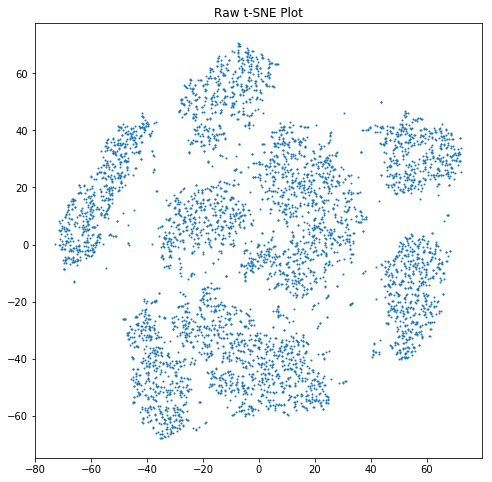

In [14]:
tsne = TSNE(n_components=2, init='pca')
X_tsne = tsne.fit_transform(X_pca)

print('X_tsne shape:',X_tsne.shape)

plot_clusters(X_tsne,y=None,model_type=None)

Now let's do some clustering on our dataset. The most popular clustering algorithm is _k-means clustering_, probably the simplest and most well-known clustering technique out there. k-means clustering acts by using an interative procedure to find the $k$ best local averages in the data. These _centroids_ are then used to determine what clusters the algorithm comes up with. Given a point, to determine what cluster it's in you find its closest centroid and give it the label of that centroid. Of course, the first question you should ask yourself is what value of $k$ you should choose. The algorithm doesn't do this for you, you have to specify it. This is perhaps the algorithm's biggest weakness, because we often don't know how many clusters there really should be in the data. 

We can find a good value of $k$ by looking for the "elbow" in the plot of the _within points scatter_, which you can think of as a type of unsupervised loss. There's no clearly discernable elbow in this plot at least up to $k=20$, suggesting k-means may not give very good clusters for this particular dataset. Since we "know" in advance that there are 10 digits, intuition suggests that taking $k=10$ here should be a reasonable choice. Let's see.

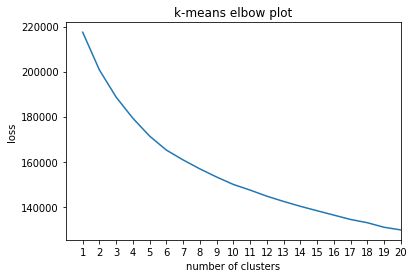

In [5]:
elbow_plot(X_pca,model_type='k-means',max_clusters=20)

Now that we have a decent value for $k$, we can set up our clustering model. Notice the API for `KMeans` is very similar to the ones we saw before for supervised learning, we instantiate the model and then fit it on the data. Since this is an unsupervised model, we only fit it on the input data `X_pca`. Once we've done that, we can generate the cluster labels by calling the `predict` method. We then use this to plot what the clusters look like on our 2D projected data. How does it look? Did we choose the right number of clusters? Feel free to vary the value of $k$ by changing the `n_clusters` parameter.

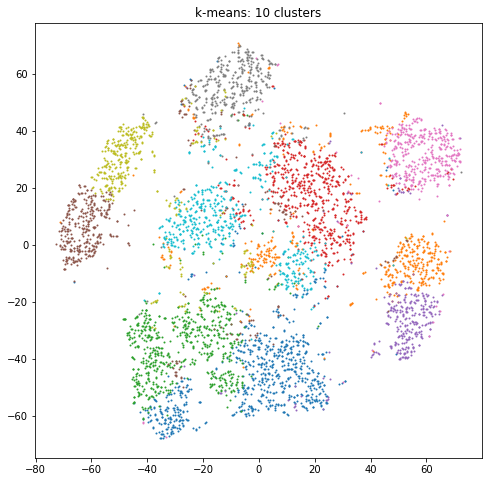

In [6]:
model = KMeans(n_clusters=10,n_jobs=-1)
model.fit(X_pca)
yhat = model.predict(X_pca)    
plot_clusters(X_tsne,yhat,'k-means')

One reason the above clusters don't look like they "should" is because k-means is a simple clustering model. It doesn't take shapes or densities of clusters into account very well. K-means is used in practice because it is _fast_, not because it's the best at finding clusters. In fact, k-means isn't guaranteed to give you the same clusters each time you run the model. It's not even guaranteed to converge at all!

One simple extension to k-means we can try is the _Gaussian Mixture Model_. This is an extension of k-means that allows clusters to be elliptical instead of just spherical. It is also a probability model, meaning it can be used for anomaly detection as well (classify low-probability points as anomalies). 

Here the GMM clusters don't have a clear "elbow" either. We just take `n_clusters` to be 10 and plot the results. Do the clusters look any better?

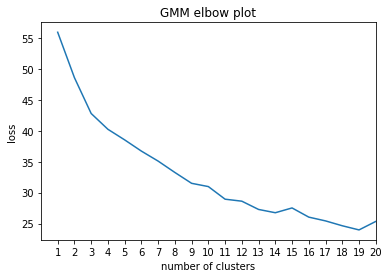

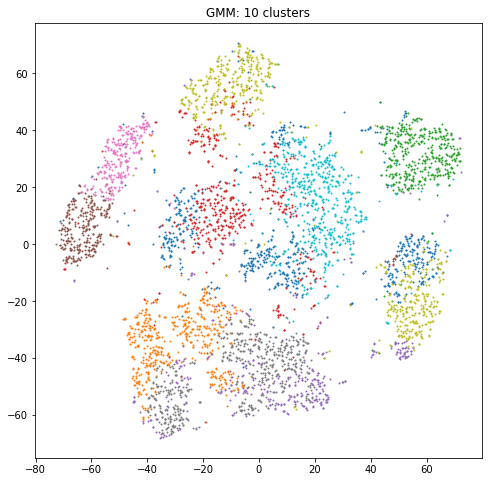

In [7]:
elbow_plot(X_pca,model_type='GMM',max_clusters=20)    
model = GaussianMixture(n_components=10)
model.fit(X_pca)
yhat = model.predict(X_pca)    
plot_clusters(X_tsne,yhat,'GMM')

Now we quickly look at examples of non-parametric clustering models. One tree-based method is _hierarchical clustering_, aka _agglomerative clustering_. HC works by first starting with each point having its own cluster, and then steadily assembles them together to create super-clusters around them. It does this over and over until all points lie in one cluster. Thus, HC can generate clusters within clusters, which is sometimes useful. The HC process can be visualized with a _dendrogram_, which shows where it adds new clusters (read bottom-up).

We first plot the dendrogram using the `scipy` library, as `sklearn` doesn't have a built in function for this as far as I could find. We then define an HM model and show a plot of the model with 5 clusters below.

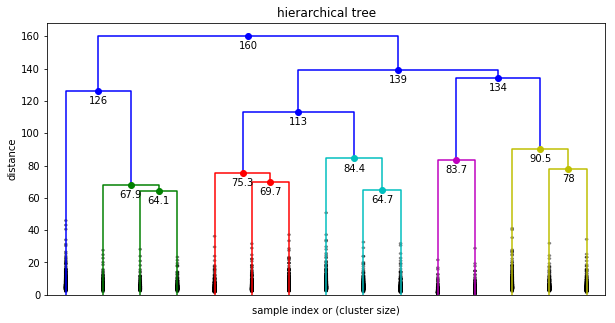

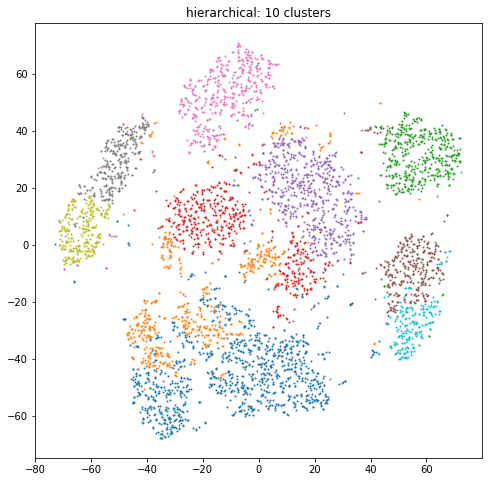

In [8]:
tree_plot(X_pca,15)

model = AgglomerativeClustering(n_clusters=10)
model.fit(X_pca)
yhat = model.labels_  
plot_clusters(X_tsne,yhat,'hierarchical')

We finish up by showing the _DBSCAN_ clustering algorithm. DBSCAN works by looking for regions of high density (number of points in a given radius) and classifying them into clusters. One great thing about DBSCAN is you don't have to tell it how many clusters to find, it finds them itself. Partly because of this, DBSCAN is widely used in practice to generate clusters on the fly when something better than k-means is desired. Like other clustering methods, it's also great for anomaly detection as well (classify points in areas of low density as anomalies).

Unfortunately, DBSCAN doesn't seem to work well with our data, at least without lots of hyperparameter tuning. The reason is possibly that the clusters aren't that well separated, there is a lot of bleed between them, which makes it hard for DBSCAN to find enough regions of high density to make decent clusters.

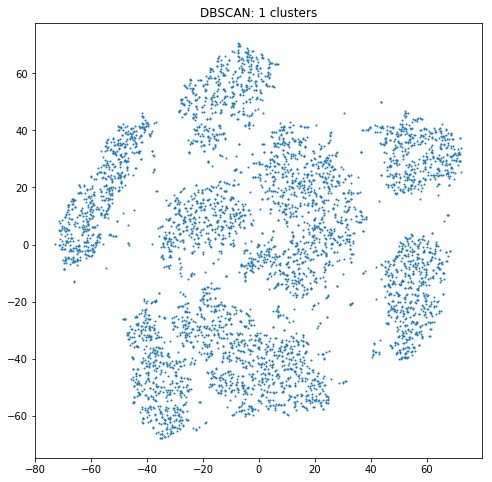

In [9]:
model = DBSCAN(eps=10.,min_samples=20,metric='euclidean',n_jobs=-1)
model.fit(X_pca)
yhat = model.labels_
plot_clusters(X_tsne,yhat,'DBSCAN')

We finish by showing the "real" labels in the dataset, i.e. the _ground truth_ labels. Since we had labels with this dataset (i.e. what digit is each image), we can see what the "real" clusters should look like. Note you almost never get this benefit when doing real-life clustering since you usually don't have the labels. Which clustering algorithm do you think did the best job of predicting these labels?

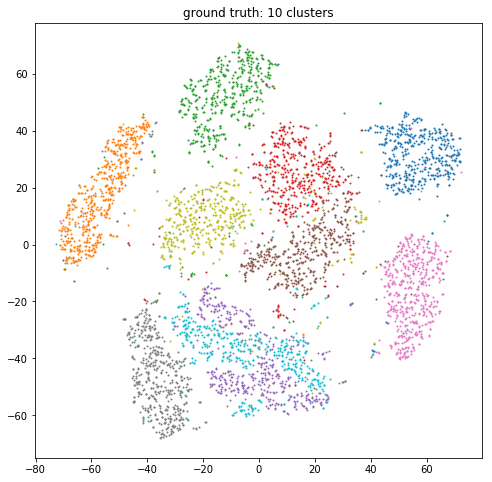

In [10]:
plot_clusters(X_tsne,y,'ground truth')